In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier, plot_importance
import preprof               ## my functions!

# BOW XGB
## imports & setup

In [2]:
bow_matrix=pickle.load(open('bow_matrix', 'rb'))

csv = '/Users/cdw/Desktop/pkpd_script/RNR_ANALYSIS/ready_processed.csv'
papers=pd.read_csv(csv)
y = papers.loc[:,'category']

bow_nofeats=pickle.load(open('bow_nofeats','rb'))
bow_nofeats=pd.DataFrame(bow_nofeats.toarray())

x_train,x_test,y_train,y_test=train_test_split(bow_nofeats,y,test_size=0.15,random_state=61097,stratify=y)

In [3]:
preprof.print_proportions(y_train,y_test)

TRAINING
 Not relevant    63.789869
Relevant        36.210131
Name: category, dtype: float64

TESTING
 Not relevant    63.60424
Relevant        36.39576
Name: category, dtype: float64


In [4]:
model=XGBClassifier().fit(x_train,y_train)

## feature importance plotting & identification

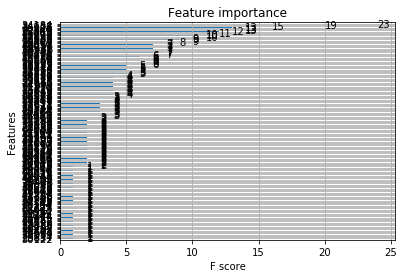

In [5]:
ax = plot_importance(model)
fig = ax.figure
#plt.savefig('bow_featimp.png')

In [6]:
## nparray of numerical importances, with dropped weird column
feat_importance=np.array(list(model.feature_importances_[0:48])+list(model.feature_importances_[49:]))

## list of feature names in order
feature_names=list(bow_matrix)

In [7]:
##returns index values for the num_feats highest values

def max_ind(array,num_feats):
    return list(array.argsort()[-num_feats:][::-1])

In [8]:
## prints top n features
def top_n_feats(feature_names,feat_importance,n):
    top = []
    for x in max_ind(feat_importance,n):
        top.append(feature_names[x])
    return top

In [9]:
topfeats=top_n_feats(feature_names,feat_importance,20)
for x in topfeats:
    print(x)

pharmacokinet
plasma
pharmacokineticsT
adultM
review
drug
clearanc
half-lif
patient
disposit
serum
mg/kg
animalsM
maleM
drug interactionsM
cross-over studiesM
specif
clinic
concentr
maximum


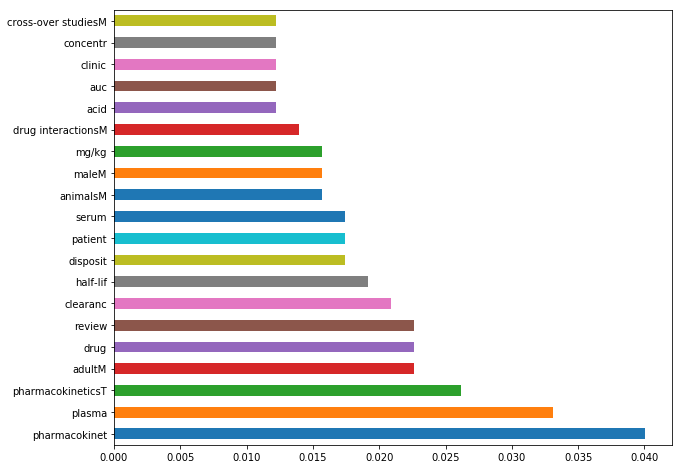

In [10]:
data=pd.Series(feat_importance, index=feature_names).nlargest(20)
fig=data.plot(kind='barh',figsize=(10,8))
fig.figure.savefig('top28_bow.png')

## feature selection

In [11]:
thresholds = sorted(list(np.unique(model.feature_importances_)))

In [ ]:
thresh_acc={}

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_x_train = selection.transform(x_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_x_train, y_train)
    # eval model
    select_x_test = selection.transform(x_test)
    y_pred = selection_model.predict(select_x_test)
    accuracy = accuracy_score(y_test, y_pred)
    thresh_acc[thresh]=accuracy
    print("Thresh=%.5f, n=%d, Accuracy: %.2f%%" % (thresh, select_x_train.shape[1], accuracy*100.0))

In [ ]:
plt.scatter(thresh_acc.keys(),thresh_acc.values(),marker='.')
plt.ylabel('% accuracy')
plt.xlabel('features importance threshold for selection')
plt.title('accuracy vs selection threshold')
plt.savefig('bow_thresh.png')
plt.show()

so we can use a threshold of 0.007 where n=55 as this achieves greater accuracy than using all 42k features!!<br>
This minimises the amount of required computational power.

## evaluation of model w selected features

In [ ]:
selection = SelectFromModel(model, threshold=0.006968641, prefit=True)
select_x_train = selection.transform(x_train)
select_x_test = selection.transform(x_test)
select_dataset = selection.transform(bow_nofeats)
select_dataset.shape

In [ ]:
pickle.dump(select_dataset,open('selected_bow','wb'))

In [ ]:
f_model = XGBClassifier().fit(select_x_train,y_train)
fy_pred=f_model.predict(select_x_test)
print('acc: {}'.format(accuracy_score(y_test,fy_pred)))
print('f1: {}'.format(f1_score(y_test,fy_pred,pos_label='Relevant')))
print(classification_report(y_test,fy_pred))

<br><br><br><br><br><br><br><br><br><br>

# TFIDF XGB
## imports & setup

In [ ]:
tfidf_matrix=pickle.load(open('tfidf_matrix', 'rb'))

csv = '/Users/cdw/Desktop/pkpd_script/RNR_ANALYSIS/ready_processed.csv'
papers=pd.read_csv(csv)
y = papers.loc[:,'category']

tfidf_nofeats=pickle.load(open('tfidf_nofeats','rb'))
tfidf_nofeats=pd.DataFrame(tfidf_nofeats.toarray())

x_train,x_test,y_train,y_test=train_test_split(tfidf_nofeats,y,test_size=0.15,random_state=61097,stratify=y)

In [ ]:
preprof.print_proportions(y_train,y_test)

In [ ]:
model=XGBClassifier().fit(x_train,y_train)

## feature importance plotting & identification

In [ ]:
ax = plot_importance(model)
fig = ax.figure
#plt.savefig('tfidf_featimp.png')

In [ ]:
## nparray of numerical importances, with dropped weird column
feat_importance=np.array(list(model.feature_importances_[0:48])+list(model.feature_importances_[49:]))

## list of feature names in order
feature_names=list(tfidf_matrix)

In [ ]:
##returns index values for the num_feats highest values

def max_ind(array,num_feats):
    return list(array.argsort()[-num_feats:][::-1])

In [ ]:
## prints top n features
def top_n_feats(feature_names,feat_importance,n):
    top = []
    for x in max_ind(feat_importance,n):
        top.append(feature_names[x])
    return top

In [ ]:
top_20=top_n_feats(feature_names,feat_importance,20)
for x in top_20:
    print(x)

In [ ]:
data=pd.Series(feat_importance, index=feature_names).nlargest(20)
fig=data.plot(kind='barh',figsize=(10,8))
fig.figure.savefig('top20_tfidf.png')

## feature selection

In [ ]:
thresholds = sorted(list(np.unique(model.feature_importances_)))

In [ ]:
thresh_acc={}

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_x_train = selection.transform(x_train)
    # train model
    selection_model = XGBClassifier().set_params(**params_tfidf)
    selection_model.fit(select_x_train, y_train)
    # eval model
    select_x_test = selection.transform(x_test)
    y_pred = selection_model.predict(select_x_test)
    accuracy = accuracy_score(y_test, y_pred)
    thresh_acc[thresh]=accuracy
    print("Thresh=%.5f, n=%d, Accuracy: %.2f%%" % (thresh, select_x_train.shape[1], accuracy*100.0))

In [ ]:
plt.scatter(thresh_acc.keys(),thresh_acc.values(),marker='.')
plt.ylabel('% accuracy')
plt.xlabel('features importance threshold for selection')
plt.title('accuracy vs selection threshold')
plt.savefig('tfidf_thresh.png')
plt.show()

so we can use a threshold of 0.005 where n=192 as this achieves almost the same accuracy as using all 42k features.<br>
There's a trade-off between the number computational power and accuracy but it's worth it.

## evaluation of model w selected features

In [ ]:
selection = SelectFromModel(model, threshold=0.0067, prefit=True)
select_x_train = selection.transform(x_train)
select_x_test = selection.transform(x_test)
select_data=selection.transform(tfidf_nofeats)
select_x_train.shape

In [ ]:
pickle.dump(select_data,open('selected_tfidf','wb'))

In [ ]:
f_model = XGBClassifier().fit(select_x_train,y_train)
fy_pred=f_model.predict(select_x_test)
print(accuracy_score(y_test,fy_pred))
print(f1_score(y_test,fy_pred,pos_label='Relevant'))
print(classification_report(y_test,fy_pred))